# Entity Recognition with LLMs

<div align="left">
<a target="_blank" href="https://console.anyscale.com/"><img src="https://img.shields.io/badge/🚀 Run_on-Anyscale-9hf"></a>&nbsp;
<a href="https://github.com/anyscale/e2e-llm-workflows" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
</div>

An end-to-end tutorial where we'll **fine-tune** an LLM to perform **batch inference** and **online serving** at scale. While entity recognition (NER) is the main task in this tutorial, we can easily extend these end-to-end workflows to any use case.

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/e2e_llm.png" width=800>

**Note**: the intent of this tutorial is to show how Ray can be use to implement end-to-end LLM workflows that can extend to any use case (including multimodal).

We'll be using the [Ray library](https://github.com/ray-project/ray) to implement these workflows, namely the LLM APIs:

[`ray.data.llm`](https://docs.ray.io/en/latest/data/working-with-llms.html):
- Batch inference over distributed datasets
- Streaming and async execution for throughput
- Built-in metrics and tracing (+ observability)
- Zero-copy GPU data transfer
- Composable with preprocessing and postprocessing steps

[`ray.serve.llm`](https://docs.ray.io/en/latest/serve/llm/serving-llms.html):
- Automatic scaling and load balancing
- Unified multi-node multi-model deployment
- Multi-LoRA support with shared base models
- Deep integration with inference engines (vLLM to start)
- Composable multi-model LLM pipelines

And all of these workloads come with all the observability views we’ll need to debug/tune them to **maximize throughput/latency**.

# Set up

## Compute
This [Anyscale Workspace](https://docs.anyscale.com/platform/workspaces/) will automatically provision and autoscale the compute our workloads will need. If you're not on Anyscale, then you will need to provision `4xA10G:48CPU-192GB` for this tutorial.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/compute.png" width=500>

## Dependencies
Let's start by downloading the dependencies required for this tutorial. You'll notice in our [`containerfile`](https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/containerfile) we have a base image [anyscale/ray-llm:2.44.1-py311-cu124](https://hub.docker.com/layers/anyscale/ray-llm/2.44.1-py311-cu124/images/sha256-8099edda787fc96847af7e1c51f30ad09792aa250efa27f9aa825b15016e6b3f) followed by a list of pip packages. If you're not on any [Anyscale](https://console.anyscale.com/), you can pull this docker image yourself and install the dependencies.


In [ ]:
%%bash
# Install dependencies
pip install -q \
    "xgrammar==0.1.11" \
    "pynvml==12.0.0" \
    "hf_transfer==0.1.9" \
    "tensorboard==2.19.0" \
    "llamafactory@git+https://github.com/hiyouga/LLaMA-Factory.git@ac8c6fdd3ab7fb6372f231f238e6b8ba6a17eb16#egg=llamafactory"

Successfully registered `ray, vllm` and 5 other packages to be installed on all cluster nodes.
View and update dependencies here: https://console.anyscale.com/cld_kvedZWag2qA8i5BjxUevf5i7/prj_cz951f43jjdybtzkx1s5sjgz99/workspaces/expwrk_mp8cxvgle2yeumgcpu1yua2r3e?workspace-tab=dependencies


# Data ingestion

In [ ]:
import json
import textwrap
from IPython.display import Code, Image, display

We'll start by downloading our data from cloud storage to local shared storage. 

In [ ]:
%%bash
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 cp  s3://viggo-ds/train.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/val.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/test.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/dataset_info.json /mnt/cluster_storage/viggo/

download: s3://viggo-ds/train.jsonl to ../../../mnt/cluster_storage/viggo/train.jsonl
download: s3://viggo-ds/val.jsonl to ../../../mnt/cluster_storage/viggo/val.jsonl
download: s3://viggo-ds/test.jsonl to ../../../mnt/cluster_storage/viggo/test.jsonl
download: s3://viggo-ds/dataset_info.json to ../../../mnt/cluster_storage/viggo/dataset_info.json


In [ ]:
%%bash
head -n 1 /mnt/cluster_storage/viggo/train.jsonl | python3 -m json.tool

{
    "instruction": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
    "input": "Blizzard North is mostly an okay developer, but they released Diablo II for the Mac and so that pushes the game from okay to good in my view.",
    "output": "give_opinion(name[Diablo II], developer[Blizzard North], rating[good], has_mac_release[yes])"
}


In [ ]:
with open("/mnt/cluster_storage/viggo/train.jsonl", "r") as fp:
    first_line = fp.readline()
    item = json.loads(first_line)
system_content = item["instruction"]
print(textwrap.fill(system_content, width=80))

Given a target sentence construct the underlying meaning representation of the
input sentence as a single function with attributes and attribute values. This
function should describe the target string accurately and the function must be
one of the following ['inform', 'request', 'give_opinion', 'confirm',
'verify_attribute', 'suggest', 'request_explanation', 'recommend',
'request_attribute']. The attributes must be one of the following: ['name',
'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres',
'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam',
'has_linux_release', 'has_mac_release', 'specifier']


We also have an info file that identifies the datasets and format --- alpaca and sharegpt (great for multimodal tasks) formats are supported --- to use for post training.

In [ ]:
display(Code(filename="/mnt/cluster_storage/viggo/dataset_info.json", language="json"))

{
    "viggo-train": {
        "file_name": "/mnt/cluster_storage/viggo/train.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    },
    "viggo-val": {
        "file_name": "/mnt/cluster_storage/viggo/val.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    }
}

# Distributed fine-tuning

We'll use [Ray Train](https://docs.ray.io/en/latest/train/train.html) + [LLaMA-Factory](https://github.com/hiyouga/LLaMA-Factory) to peform multinode training. The parameters for our training workload -- post-training method, dataset location, train/val details, etc. --- can be found in the `llama3_lora_sft_ray.yaml` config file. Check out recipes for even more post-training methods (sft, pretraining, ppo, dpo, kto, etc.) [here](https://github.com/hiyouga/LLaMA-Factory/tree/main/examples).

**Note**: We also support using other tools like [axolotl](https://axolotl-ai-cloud.github.io/axolotl/docs/ray-integration.html) or even [Ray Train + HF Accelreate + FSDP/Deepspeed](https://docs.ray.io/en/latest/train/huggingface-accelerate.html) directly for complete control of your post-training workloads.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/distributed_training.png" width=800>

## Config

In [ ]:
import os
from pathlib import Path
import yaml

In [ ]:
display(Code(filename="lora_sft_ray.yaml", language="yaml"))

### model
model_name_or_path: Qwen/Qwen2.5-7B-Instruct
trust_remote_code: true

### method
stage: sft
do_train: true
finetuning_type: lora
lora_rank: 8
lora_target: all

### dataset
dataset: viggo-train
dataset_dir: /mnt/cluster_storage/viggo  # shared storage workers have access to
template: qwen
cutoff_len: 2048
max_samples: 1000
overwrite_cache: true
preprocessing_num_workers: 16
dataloader_num_workers: 4

### output
output_dir: /mnt/cluster_storage/viggo/outputs  # should be somewhere workers have access to (ex. s3, nfs)
logging_steps: 10
save_steps: 500
plot_loss: true
overwrite_output_dir: true
save_only_model: false

### ray
ray_run_name: lora_sft_ray
ray_storage_path: /mnt/cluster_storage/viggo/saves  # should be somewhere workers have access to (ex. s3, nfs)
ray_num_workers: 4
resources_per_worker:
  GPU: 1
  anyscale/accelerator_shape:4xA10G: 1  # Use this to specify a specific node shape,
  # accelerator_type:A10G: 1           # Or use this to simply specify a GPU type.
  # see https://docs.ray.io/en/master/ray-core/accelerator-types.html#accelerator-types for a full list of accelerator types
placement_strategy: PACK

### train
per_device_train_batch_size: 1
gradient_accumulation_steps: 8
learning_rate: 1.0e-4
num_train_epochs: 5.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: true
ddp_timeout: 180000000
resume_from_checkpoint: null

### eval
eval_dataset: viggo-val  # uses same dataset_dir as training data
# val_size: 0.1  # only if using part of training data for validation
per_device_eval_batch_size: 1
eval_strategy: steps
eval_steps: 500

In [ ]:
model_id = "ft-model"  # call it whatever you want
model_source = yaml.safe_load(open("lora_sft_ray.yaml"))["model_name_or_path"]  # HF model ID, S3 mirror config, or GCS mirror config
print (model_source)

Qwen/Qwen2.5-7B-Instruct


## Multi-node training

We'll be using Ray Train + LlamaFactory to perform the mult-node train loop.

<div class="alert alert-block alert"> <b>Ray Train</b> 

Using [Ray Train](https://docs.ray.io/en/latest/train/train.html) here has several advantages:
- automatically handles **multi-node, multi-GPU** setup with no manual SSH setup or hostfile configs. 
- define **per-worker franctional resource requirements** (e.g., 2 CPUs and 0.5 GPU per worker)
- run on **heterogeneous machines** and scale flexibly (e.g., CPU for preprocessing and GPU for training) 
- built-in **fault tolerance** via retry of failed workers (and continue from last checkpoint).
- supports Data Parallel, Model Parallel, Parameter Server, and even custom strategies.
- [Ray Compiled graphs](https://docs.ray.io/en/latest/ray-core/compiled-graph/ray-compiled-graph.html) allow us to even define different parallelism for jointly optimizing multipe models (Megatron, Deepspeed, etc. only allow for one global setting).

[RayTurbo Train](https://docs.anyscale.com/rayturbo/rayturbo-train) offers even more improvement to the price-performance ratio, performance monitoring and more:
- **elastic training** to scale to a dynamic number of workers, continue training on fewer resources (even on spot instances).
- **purpose-built dashboard** designed to streamline the debugging of Ray Train workloads
    - Monitoring: View the status of training runs and train workers.
    - Metrics: See insights on training throughput, training system operation time.
    - Profiling: Investigate bottlenecks, hangs, or errors from individual training worker processes.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/train_dashboard.png" width=700>

In [ ]:
%%bash
# Run multinode distributed fine-tuning workload
USE_RAY=1 llamafactory-cli train lora_sft_ray.yaml



Training started with configuration:
    ╭──────────────────────────────────────────────────────────────────────────────────────────────────────╮
    │ Training config                                                                                      │
    ├──────────────────────────────────────────────────────────────────────────────────────────────────────┤
    │ train_loop_config/args/bf16                                                                     True │
    │ train_loop_config/args/cutoff_len                                                               2048 │
    │ train_loop_config/args/dataloader_num_workers                                                      4 │
    │ train_loop_config/args/dataset                                                           viggo-train │
    │ train_loop_config/args/dataset_dir                                              ...ter_storage/viggo │
    │ train_loop_config/args/ddp_timeout                                                 

In [ ]:
display(Code(filename="/mnt/cluster_storage/viggo/outputs/all_results.json", language="json"))

{
    "epoch": 4.864,
    "eval_viggo-val_loss": 0.13618840277194977,
    "eval_viggo-val_runtime": 20.2797,
    "eval_viggo-val_samples_per_second": 35.208,
    "eval_viggo-val_steps_per_second": 8.827,
    "total_flos": 4.843098686147789e+16,
    "train_loss": 0.2079355036479331,
    "train_runtime": 437.2951,
    "train_samples_per_second": 11.434,
    "train_steps_per_second": 0.354
}

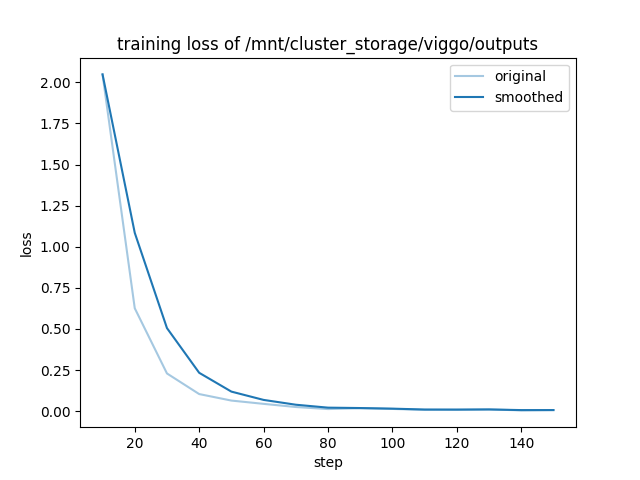

In [ ]:
display(Image(filename="/mnt/cluster_storage/viggo/outputs/training_loss.png"))

## Observability

<div class="alert alert-block alert"> <b> 🔎 Monitoring and Debugging with Ray</b> 


OSS Ray offers an extensive [observability suite](https://docs.ray.io/en/latest/ray-observability/index.html) that offers logs and an observability dashboard that we can use to monitor and debug. The dashboard includes a lot of different components such as:

-  memory, utilization, etc. of the tasks running in our [cluster](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-node-view)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cluster_util.png" width=700>

- views to see all our running tasks, utilization across instance types, autoscaling, etc.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/observability_views.png" width=1000>


<div class="alert alert-block alert"> <b> 🔎➕➕ Monitoring and Debugging on Anyscale</b> 

While OSS Ray comes with an extensive obervability suite, Anyscale takes it many steps further to make it even easier and faster to monitor and debug your workloads.

- [unified log viewer](https://docs.anyscale.com/monitoring/accessing-logs/) to see logs from *all* our driver and worker processes
- Ray workload specific dashboard (Data, Train, etc.) that can breakdown the tasks. For example, our training workload above can be observed live through the Train specific Ray Workloads dashboard:

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/train_dashboard.png" width=700>




## Save to cloud storage

<div class="alert alert-block alert"> <b> 🗂️ Storage on Anyscale</b> 

We can always store to our data inside [any storage buckets](https://docs.anyscale.com/configuration/storage/#private-storage-buckets) but Anyscale offers a [default storage bucket](https://docs.anyscale.com/configuration/storage/#anyscale-default-storage-bucket) to make things even easier. We also have plenty of other [storage options](https://docs.anyscale.com/configuration/storage/) as well (shared at the cluster, user and cloud levels).

In [ ]:
%%bash
# Anyscale default storage bucket
echo $ANYSCALE_ARTIFACT_STORAGE

s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage


In [ ]:
%%bash
# Save fine-tuning artifacts to cloud storage
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet
aws s3 cp /mnt/cluster_storage/viggo/outputs $ANYSCALE_ARTIFACT_STORAGE/viggo/outputs --recursive --quiet
aws s3 cp $2 /mnt/cluster_storage/viggo/saves $ANYSCALE_ARTIFACT_STORAGE/viggo/saves --recursive --quiet

In [ ]:
%%bash
ls /mnt/cluster_storage/viggo/saves/lora_sft_ray

TorchTrainer_95d16_00000_0_2025-04-11_14-47-37
TorchTrainer_f9e4e_00000_0_2025-04-11_12-41-34
basic-variant-state-2025-04-11_12-41-34.json
basic-variant-state-2025-04-11_14-47-37.json
experiment_state-2025-04-11_12-41-34.json
experiment_state-2025-04-11_14-47-37.json
trainer.pkl
tuner.pkl


In [ ]:
# LoRA paths
save_dir = Path("/mnt/cluster_storage/viggo/saves/lora_sft_ray")
trainer_dirs = [d for d in save_dir.iterdir() if d.name.startswith("TorchTrainer_") and d.is_dir()]
latest_trainer = max(trainer_dirs, key=lambda d: d.stat().st_mtime, default=None)
lora_path = f"{latest_trainer}/checkpoint_000000/checkpoint"
s3_lora_path = os.path.join(os.getenv("ANYSCALE_ARTIFACT_STORAGE"), lora_path.split("/mnt/cluster_storage/")[-1])
dynamic_lora_path, lora_id = s3_lora_path.rsplit("/", 1)
print (lora_path)
print (s3_lora_path)
print (dynamic_lora_path)
print (lora_id)

/mnt/cluster_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000/checkpoint
s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000/checkpoint
s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/lora_sft_ray/TorchTrainer_95d16_00000_0_2025-04-11_14-47-37/checkpoint_000000
checkpoint


In [ ]:
%%bash -s "$lora_path"
ls $1

README.md
adapter_config.json
adapter_model.safetensors
added_tokens.json
merges.txt
optimizer.pt
rng_state_0.pth
rng_state_1.pth
rng_state_2.pth
rng_state_3.pth
scheduler.pt
special_tokens_map.json
tokenizer.json
tokenizer_config.json
trainer_state.json
training_args.bin
vocab.json


# Batch inference 
[`Overview`](https://docs.ray.io/en/latest/data/working-with-llms.html) |  [`API reference`](https://docs.ray.io/en/latest/data/api/llm.html)

The `ray.data.llm` module integrates with key large language model (LLM) inference engines and deployed models to enable LLM batch inference. These llm modules use [Ray Data](https://docs.ray.io/en/latest/data/data.html) under the hood, which makes it extremely easy to distribute our workloads but also ensures that they happen:
- **efficiently**: minimize CPU/GPU idletime with hetergenous resource scheduling.
- **at scale**: streaming execution to petabyte-scale datasets (especially when [working with LLMs](https://docs.ray.io/en/latest/data/working-with-llms.html))
- **reliably** by checkpointing processes, especially when running workloads on spot instanes (with on-demand fallback).
- **flexiblibly**: connect to data from any source, apply your transformations and save to any format/location for your next workload.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_data_solution.png" width=800>

[RayTurbo Data](https://docs.anyscale.com/rayturbo/rayturbo-data) has even more functionality on top of Ray Data:
- **accelerated metadata fetching** to improve reading first time from large datasets 
- **optimized autoscaling** where Jobs can kick off before waiting for the entire cluster to start
- **high reliabilty** where entire fails jobs (head node, cluster, uncaptured exceptions, etc.) can resume from checkpoints (OSS Ray can only recover from worker node failures)

Let's start by defining the [vLLM engine processor config](https://docs.ray.io/en/latest/data/api/doc/ray.data.llm.vLLMEngineProcessorConfig.html#ray.data.llm.vLLMEngineProcessorConfig) where we can select the model we want to use and the [engine behavior](https://docs.vllm.ai/en/stable/serving/engine_args.html). The model can come from [HuggingFace (HF) Hub](https://huggingface.co/models) or a local model path `/path/to/your/model` (GPTQ, GGUF, or LoRA model formats supported).

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/data_llm.png" width=800>

## vLLM engine processor

In [ ]:
import os
import ray
from ray.data.llm import vLLMEngineProcessorConfig

INFO 04-11 14:58:40 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [ ]:
config = vLLMEngineProcessorConfig(
    model_source=model_source,
    # runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    engine_kwargs={
        "enable_lora": True,
        "max_lora_rank": 8,
        "max_loras": 1,
        "pipeline_parallel_size": 1,
        "tensor_parallel_size": 1,
        "enable_prefix_caching": True,
        "enable_chunked_prefill": True,
        "max_num_batched_tokens": 4096,
        "max_model_len": 4096,  # or increase KV cache size
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
    concurrency=1,
    batch_size=16,
    accelerator_type="A10G",
)

## LLM processor

Next, we'll pass our config to an [llm processor](https://docs.ray.io/en/master/data/api/doc/ray.data.llm.build_llm_processor.html#ray.data.llm.build_llm_processor) where we can define the preprocessing and postprocessing steps around inference. With our base model defined in the processor config, we can define the lora adapter layers as part of the preprocessing step of the llm processor itself.

In [ ]:
from ray.data.llm import build_llm_processor

In [ ]:
processor = build_llm_processor(
    config,
    preprocess=lambda row: dict(
        model=lora_path,  # REMOVE this line if doing inference with just the base model
        messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": row["input"]}
        ],
        sampling_params={
            "temperature": 0.3,
            "max_tokens": 250,
            # complete list: https://docs.vllm.ai/en/stable/api/inference_params.html
        },
    ),
    postprocess=lambda row: {
        **row,  # all contents
        "generated_output": row["generated_text"],
        # add additional outputs
    },
)

2025-04-11 14:58:40,942	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.51.51:6379...
2025-04-11 14:58:40,953	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-zt5t77xa58pyp3uy28glg2g24d.i.anyscaleuserdata.com 
2025-04-11 14:58:40,960	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_e71d58b4dc01d065456a9fc0325ee2682e13de88.zip' (2.16MiB) to Ray cluster...
2025-04-11 14:58:40,969	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_e71d58b4dc01d065456a9fc0325ee2682e13de88.zip'.


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

(pid=51260) INFO 04-11 14:58:47 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [ ]:
# Evaluation on test dataset
ds = ray.data.read_json("/mnt/cluster_storage/viggo/test.jsonl")  # complete list: https://docs.ray.io/en/latest/data/api/input_output.html
ds = processor(ds)
results = ds.take_all()
results[0]



{
  "batch_uuid": "d7a6b5341cbf4986bb7506ff277cc9cf",
  "embeddings": null,
  "generated_text": "request(esrb)",
  "generated_tokens": [2035, 50236, 10681, 8, 151645],
  "input": "Do you have a favorite ESRB content rating?",
  "instruction": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
  "messages": [
    {
      "content": "Given a target sentence construct the underlying meaning

In [ ]:
# Exact match (strict!)
matches = 0
for item in results:
    if item["output"] == item["generated_output"]:
        matches += 1
matches / float(len(results))

0.6879039704524469

**Note**: the objective of fine-tuning here is not to create the most performant model (increase `num_train_epochs` if you want to though) but to show it can be leveraged for downstream workloads (batch inference and online serving) at scale.

We can observe the individual steps in our our batch inference workload through the Anyscale Ray Data dashboard:

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/data_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like optimized model loading, multi-lora, openai-compatible endpoints, etc. check out [more examples](https://docs.ray.io/en/latest/data/working-with-llms.html) and the [API reference](https://docs.ray.io/en/latest/data/api/llm.html).

</div>

# Online serving
[`Overview`](https://docs.ray.io/en/latest/serve/llm/serving-llms.html) | [`API reference`](https://docs.ray.io/en/latest/serve/api/index.html#llm-api)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_serve.png" width=600>

`ray.serve.llm` APIs allow users to deploy multiple LLM models together with a familiar Ray Serve API, while providing compatibility with the OpenAI API.

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/serve_llm.png" width=500>

Ray Serve LLM is designed with the following features:
- Automatic scaling and load balancing
- Unified multi-node multi-model deployment
- OpenAI compatibility
- Multi-LoRA support with shared base models
- Deep integration with inference engines (vLLM to start)
- Composable multi-model LLM pipelines

[RayTurbo Serve](https://docs.anyscale.com/rayturbo/rayturbo-serve) on Anyscale has even more functionality on top of Ray Serve:
- **fast autoscaling and model loading** to get our services up and running even faster ([5x improvements](https://www.anyscale.com/blog/autoscale-large-ai-models-faster) even for LLMs)
- 54% **higher QPS** and up-to 3x **streaming tokens per second** for high traffic serving use-cases
- **replica compaction** into fewer nodes where possible to reduce resource fragmentation and improve hardware utilization
- **zero-downtime** [incremental rollouts](https://docs.anyscale.com/platform/services/update-a-service/#resource-constrained-updates) so your service is never interrupted
- [**different environments**](https://docs.anyscale.com/platform/services/multi-app/#multiple-applications-in-different-containers) for each service in a multi-serve application
- **multi availability-zone** aware scheduling of Ray Serve replicas to provide higher redundancy to availability zone failures


## LLM serve config

In [ ]:
import os
from openai import OpenAI  # to use openai api format
from ray import serve
from ray.serve.llm import LLMConfig, build_openai_app

Let's define an [LLM config](https://docs.ray.io/en/latest/serve/api/doc/ray.serve.llm.LLMConfig.html#ray.serve.llm.LLMConfig) where we can define where our model comes from, it's [autoscaling behavior](https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling), what hardware to use and [engine arguments](https://docs.vllm.ai/en/stable/serving/engine_args.html).

In [ ]:
# Define config
llm_config = LLMConfig(
    model_loading_config={
        "model_id": model_id,
        "model_source": model_source
    },
    lora_config={  # REMOVE this section if you are only using a base model
        "dynamic_lora_loading_path": dynamic_lora_path,
        "max_num_adapters_per_replica": 16,  # we only have 1
    },
    # runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    deployment_config={
        "autoscaling_config": {
            "min_replicas": 1,
            "max_replicas": 2,
            # complete list: https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling
        }
    },
    accelerator_type="A10G",
    engine_kwargs={
        "max_model_len": 4096,  # or increase KV cache size
        "tensor_parallel_size": 1,
        "enable_lora": True,
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
)

Now we'll deploy our llm config as an application. And since this is all built on top of [Ray Serve](https://docs.ray.io/en/latest/serve/index.html), we can have advanvced service logic around composing models together, deploying multiple applications, model multiplexing, observability, etc.

In [ ]:
# Deploy
app = build_openai_app({"llm_configs": [llm_config]})
serve.run(app)

DeploymentHandle(deployment='LLMRouter')


## Service request

In [ ]:
# Initialize client
client = OpenAI(base_url="http://localhost:8000/v1", api_key="fake-key")
response = client.chat.completions.create(
    model=f"{model_id}:{lora_id}",
    messages=[
        {"role": "system", "content": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']"},
        {"role": "user", "content": "Blizzard North is mostly an okay developer, but they released Diablo II for the Mac and so that pushes the game from okay to good in my view."},
    ],
    stream=True
)
for chunk in response:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="", flush=True)



Avg prompt throughput: 20.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.

_opinion(name[Diablo II], developer[Blizzard North], rating[good], has_mac_release[yes])




And of course, we can observe our running service (deployments and metrics like QPS, latency, etc.) through the [Ray Dashboard](https://docs.ray.io/en/latest/ray-observability/getting-started.html)'s [Serve view](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-serve-view):

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/serve_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like structured outputs (ex. json), vision LMs, multi-lora on shared base models, using other inference engines (ex. sglang), etc. fast model loading, etc. check out [more examples](https://docs.ray.io/en/latest/serve/llm/overview.html) and the [API reference](https://docs.ray.io/en/latest/serve/llm/api.html).

</div>

# Production

Seamlessly integrate with your existing CI/CD pipelines by leveraging the Anyscale [CLI](https://docs.anyscale.com/reference/quickstart-cli) or [SDK](https://docs.anyscale.com/reference/quickstart-sdk) to run [reliable batch jobs](https://docs.anyscale.com/platform/jobs) and deploy [highly available services](https://docs.anyscale.com/platform/services). Given we've been developing in an environment that's almost identical to production (multinode cluster), this should drastically speed up our dev → prod velocity.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cicd.png" width=600>

## Jobs

[Anyscale Jobs](https://docs.anyscale.com/platform/jobs/) ([API ref](https://docs.anyscale.com/reference/job-api/)) allows us to execute discrete workloads in production such as batch inference, embeddings generation, or model fine-tuning.
- [define and manage](https://docs.anyscale.com/platform/jobs/manage-jobs) our Jobs in many different ways (CLI, Python SDK)
- set up [queues](https://docs.anyscale.com/platform/jobs/job-queues) and [schedules](https://docs.anyscale.com/platform/jobs/schedules)
- set up all the [observability, alerting, etc.](https://docs.anyscale.com/platform/jobs/monitoring-and-debugging) around our Jobs

## Services

[Anyscale Services](https://docs.anyscale.com/platform/services/) ([API ref](https://docs.anyscale.com/reference/service-api/)) offers an extremely fault tolerant, scalable and optimized way to serve our Ray Serve applications.
- we can [rollout and update](https://docs.anyscale.com/platform/services/update-a-service) our services with canary deployment (zero-downtime upgrades)
- [monitor](https://docs.anyscale.com/platform/services/monitoring) our Services through a dedicated Service page, unified log viewer, tracing, set up alerts, etc.
- scale a service (`num_replicas=auto`) and utilize replica compaction to consolidate nodes that are fractionally utilized
- [head node fault tolerance](https://docs.anyscale.com/platform/services/production-best-practices#head-node-ft) (OSS Ray recovers from failed workers and replicas but not head node crashes)
- serving [muliple applications](https://docs.anyscale.com/platform/services/multi-app) in a single Service

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/canary.png" width=700>


In [ ]:
%%bash
# clean up
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet